In [30]:
# libraries and packages
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import yaml
import pandas as pd
from time import time
from sklearn.model_selection import cross_val_score

In [31]:
# load hyperparameters from yaml file
with open('config.yaml', 'r') as file:
    config = yaml.safe_load(file)['params']

In [32]:
# Load California housing dataset
data = fetch_california_housing()
X, y = pd.DataFrame(data.data, columns=data.feature_names), pd.Series(data.target) # series for y keeps it 1D... a df, would assume 2D and spit an error when fitting

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Cross-Validation RMSE Scores: [0.45071917 0.46131093 0.45774151 0.45381298 0.45540872]
Mean CV RMSE: 0.4557986638188491
Training time: 3.51 seconds


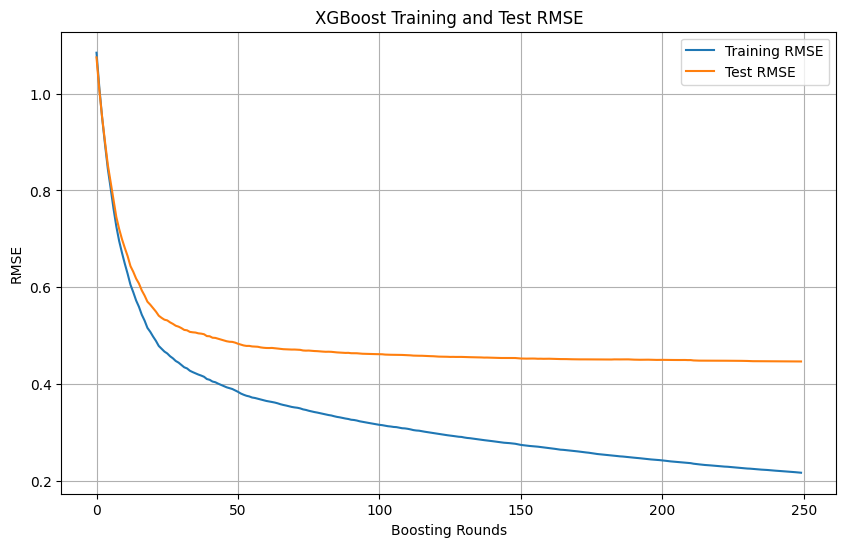

Final Test RMSE: 0.446413000379817


In [48]:
# Train XGB model
model = xgb.XGBRegressor(**config) # uses the ** to unpack the dictionary of the hyperparams # n_jobs=-1 uses all CPU cores # -2 uses all but one core
# if using cv, use n_jobs=-1 there and not above to avoid conflicts or redundant parallelism
start_time = time()
model.fit(X_train, 
          y_train,
          eval_set=[(X_train, y_train), (X_test, y_test)],
          verbose=False, # T = print each boosting round, F = silent
          )
cv_scores = cross_val_score(model, X_train, y_train, 
                           cv=5,  # 5-fold cross validation
                           scoring='neg_mean_squared_error',
                           n_jobs=-1)  # Use all available cores
cv_rmse_scores = (-cv_scores) ** 0.5
print(f"Cross-Validation RMSE Scores: {cv_rmse_scores}")
print(f"Mean CV RMSE: {cv_rmse_scores.mean()}")

# Training history
evals = model.evals_result()
train_rmse = evals['validation_0']['rmse']
test_rmse = evals['validation_1']['rmse']

end_time = time()
print(f"Training time: {end_time - start_time:.2f} seconds")

# Plot training and evaluation RMSE
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(train_rmse, label='Training RMSE')
plt.plot(test_rmse, label='Test RMSE')
plt.xlabel('Boosting Rounds')
plt.ylabel('RMSE')
plt.title('XGBoost Training and Test RMSE')
plt.legend()
plt.grid()
plt.show()

final_test_rmse = test_rmse[-1]
print(f"Final Test RMSE: {final_test_rmse}")

In [5]:
# Predict and Evaluate
# Confirm I calculated metrics correctly in code block above
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
rmse = mse ** 0.5
print(f"Root Mean Squared Error: {rmse}")

Mean Squared Error: 0.20018890748839452
Root Mean Squared Error: 0.44742475064349596
